# Cell type annotation prediction

Run this notebook on google colab to use a free GPU!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Cell-Type-Annotation.ipynb)

In this notebook, which follows the tutorial from scGPT [here](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Annotation.ipynb), an [scGPT](https://www.nature.com/articles/s41592-024-02201-0) model is used to predict a cell type annotation with a given gene expression profile. It demonstrates an efficient **transfer learning approach** for single-cell RNA sequencing analysis. The scGPT foundation model first processes raw gene expression data to extract meaningful 512-dimensional cell *embeddings that capture biological patterns*. These frozen embeddings then feed into a smaller, trainable MLP classifier that learns to map the representations to specific cell type predictions, enabling accurate classification while preserving pretrained knowledge and reducing computational costs.


![scGPT workflow](scRNA-workflow.svg)

Above diagram shows the embedding-based approach where scGPT's weights remain frozen while only a small MLP classifier is trained. In below plot, we'll see the alternative full fine-tuning approach where all of scGPT's parameters are updated during training. This comparison highlights the efficiency gains of using frozen embeddings versus comprehensive model retraining.

![scGPT workflow](full-finetune-vs-mlp-only.svg)

The same approach is made with the [Geneformer](https://www.nature.com/articles/s41586-023-06139-9.epdf?sharing_token=u_5LUGVkd3A8zR-f73lU59RgN0jAjWel9jnR3ZoTv0N2UB4yyXENUK50s6uqjXH69sDxh4Z3J4plYCKlVME-W2WSuRiS96vx6t5ex2-krVDS46JkoVvAvJyWtYXIyj74pDWn_DutZq1oAlDaxfvBpUfSKDdBPJ8SKlTId8uT47M%3D) model and the results are compared against each other.

This approach greatly reduces time and complexity.

In [1]:
# !pip install helical

In [2]:
# !pip install datasets --upgrade

In [3]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.sparse import lil_matrix
import torch.optim as optim
from helical.models.scgpt import scGPT, scGPTConfig
from helical.models.geneformer import Geneformer, GeneformerConfig
from copy import deepcopy
from torch.nn.functional import one_hot

  from pkg_resources import get_distribution, DistributionNotFound

  from .autonotebook import tqdm as notebook_tqdm

INFO:datasets:PyTorch version 2.6.0 available.


We load the our dataset from the EMBL [website](https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-11673). To download the dataset, we are leveraging Huggingface's optimized library!

In [4]:
from datasets import load_dataset
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[:65%]",download_mode="reuse_cache_if_exists")

Generating test split: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6336/6336 [00:06<00:00, 1020.88 examples/s]


In [5]:
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata = ad.AnnData(lil.tocsr(),obs=obs_data)
adata.var_names = ds.features['raw_counts'].id.split(",")
adata.var['gene_name'] = adata.var_names.str.upper()

  return dispatch(args[0].__class__)(*args, **kw)



Let's familiarise ourselves with the data!

We are interested in the names of the cells we want to predict. They are saved in `adata.obs["LVL1"]`.

Additionally, we need to know how many distinct cell types/classes we have.

In [6]:
# get labels: the celltype
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))

celltypes_labels = np.array(adata.obs["LVL1"].tolist())

This is all summarized in this dictionary:

In [7]:
id2type

{0: 'ERYTHROID',
 1: 'LYMPHOID',
 2: 'MK',
 3: 'MYELOID',
 4: 'PROGENITOR',
 5: 'STROMA'}

Use the Helical package to get the embeddings of the gene expression profile.

The only thing we need to specify is the column containing the names of the genes. (`gene_name` in this case)

The resulting embeddings are the input features `x` for our smaller NN model.

# scGPT

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
data = scgpt.process_data(adata, gene_names = "gene_name")
x_scgpt = scgpt.get_embeddings(data)
x_scgpt.shape

  warnings.warn(

INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.scgpt.model:Processing data for scGPT.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
Embedding cells: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [01:23<00:00,  3.97it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


(16474, 512)

With the input features, we also need the corresponding labels `y`.

They correspond to the cell type labels.

As we have a categorical prediction, we transform the cell type labels to integer labels to work with CrossEntropyLoss later.

In [9]:
y = celltypes_labels
num_classes = num_types

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = one_hot(torch.tensor(y_encoded),num_classes).float()

## Define and train the model

In [10]:
input_shape = 512

# Define the model architecture
head_model = nn.Sequential(
    nn.Linear(input_shape, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(32, num_classes)
    )

print(head_model)

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=32, out_features=6, bias=True)
)


In [11]:
def train_model(model: nn.Sequential,
                X_train: torch.Tensor,
                y_train: torch.Tensor,
                X_val: torch.Tensor,
                y_val: torch.Tensor,
                optimizer = optim.Adam,
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 50,
                batch = 64):

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    # Validation dataset
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()

    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # Compute loss
            loss = loss_fn(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase (optional)
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())

            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")

        # Set back to training mode for next epoch
        model.train()

    model.eval()
    return model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x_scgpt, y_encoded, test_size=0.1, random_state=42)

head_model_scgpt = deepcopy(head_model)
head_model_scgpt = train_model(head_model_scgpt,
                               torch.from_numpy(X_train),
                               y_train,
                               torch.from_numpy(X_test),
                               y_test,
                               optim.Adam(head_model_scgpt.parameters(), lr=0.001),
                               nn.CrossEntropyLoss())

Epoch 1, Validation Loss: 0.13581091717172128
Epoch 2, Validation Loss: 0.09857814778717092
Epoch 3, Validation Loss: 0.09526929816302772
Epoch 4, Validation Loss: 0.08480363461869554
Epoch 5, Validation Loss: 0.07416556593335162
Epoch 6, Validation Loss: 0.07239538945633775
Epoch 7, Validation Loss: 0.0702645217623705
Epoch 8, Validation Loss: 0.06784882291238038
Epoch 9, Validation Loss: 0.06266222532408741
Epoch 10, Validation Loss: 0.061017308836408816
Epoch 11, Validation Loss: 0.06161335325808837
Epoch 12, Validation Loss: 0.06232350710063027
Epoch 13, Validation Loss: 0.054639975365716964
Epoch 14, Validation Loss: 0.05939614326276709
Epoch 15, Validation Loss: 0.054178430983134046
Epoch 16, Validation Loss: 0.05351503950973543
Epoch 17, Validation Loss: 0.047896623985322476
Epoch 18, Validation Loss: 0.04836468111562471
Epoch 19, Validation Loss: 0.046979445281277336
Epoch 20, Validation Loss: 0.04995960127584672
Epoch 21, Validation Loss: 0.04970356199639635
Epoch 22, Validati

In [13]:
predictions_nn = head_model_scgpt(torch.Tensor(X_test))
y_pred = np.array(torch.argmax(predictions_nn, dim=1))
y_true = np.array(y_test.argmax(axis=1))

## Present the results
- on the test set and,
- a separate, unseen evaluation set

In [14]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [15]:
get_evaluations("Test set", y_true, y_pred)

  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Test set accuracy: 99.0%
Test set precision: 81.9%
Test set f1: 81.1%
Test set recall: 80.4%


{'accuracy': 0.9902912621359223,
 'precision': 0.8188892059766123,
 'f1': 0.8111486710757254,
 'recall': 0.804035184270009}

Load the unseen evaluation set:

In [16]:
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[70%:]",download_mode="reuse_cache_if_exists")

Generating test split: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6336/6336 [00:05<00:00, 1069.77 examples/s]


In [17]:
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata_unseen = ad.AnnData(lil.tocsr(),obs=obs_data)
adata_unseen.var_names = ds.features['raw_counts'].id.split(",")
adata_unseen.var['gene_name'] = adata_unseen.var_names.str.upper()

  return dispatch(args[0].__class__)(*args, **kw)



In [18]:
data_unseen = scgpt.process_data(adata_unseen, gene_names="gene_name")
x_unseen = scgpt.get_embeddings(data_unseen)
predictions_nn_unseen = head_model_scgpt(torch.Tensor(x_unseen))

INFO:helical.models.scgpt.model:Processing data for scGPT.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
Embedding cells: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:32<00:00,  4.67it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


We should double check that the cell types are mapped to the correct id numbers for both the training data and this new data set.

In [19]:
num_types = adata_unseen.obs["LVL1"].unique().shape[0]
id2type_unseen = dict(enumerate(adata_unseen.obs["LVL1"].astype("category").cat.categories))
id2type_unseen == id2type

True

In [20]:
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

scgpt_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Evaluation set accuracy: 99.2%
Evaluation set precision: 73.8%
Evaluation set f1: 75.2%
Evaluation set recall: 77.1%


Plot a confusion matrix to visualise the classification performance for each the cell type. This is done for the evalation set.

<Axes: >

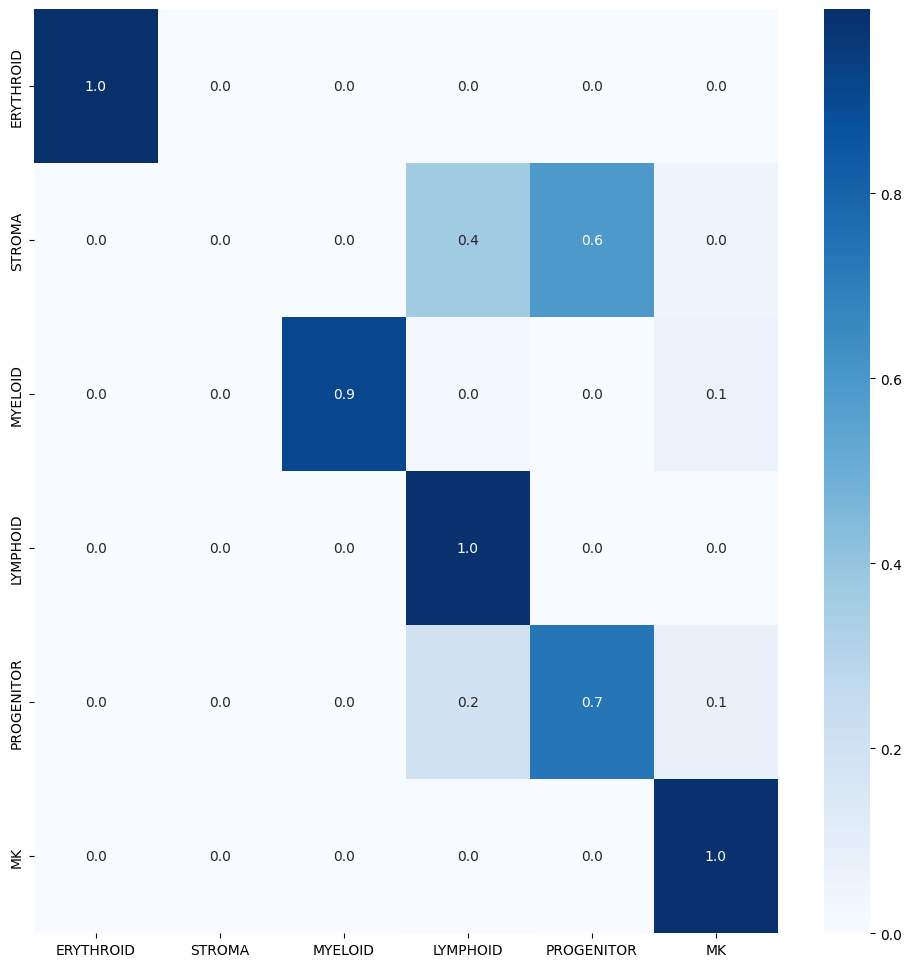

In [21]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

set_predicted_cell_types = list(adata_unseen.obs["LVL1"].unique())
for i in set(y_pred_unseen):
    if i not in set_predicted_cell_types:
        set_predicted_cell_types.remove(i)

cm = confusion_matrix(y_true_unseen, y_pred_unseen)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")

-------------

# DIY: Geneformer

The same approach is made with the Geneformer model and the results are compared against each other.

Let's do the same with the Geneformer.

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if 'rows' in adata.obs:
    adata.obs['rows'] = adata.obs['rows'].astype(str)
geneformer_config = GeneformerConfig(batch_size=50, device=device)
geneformer = Geneformer(configurer = geneformer_config)

INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-38M-i4096' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.


In [23]:
data_geneformer = geneformer.process_data(adata, gene_names = "gene_name")
data_geneformer

INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/biosc05/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/biosc05/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/biosc05/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 21111 genes to Ensembl IDs from a total of 37318 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 16474 × 37318
    obs: 'rows', 'size', 'LVL1', 'LVL2', 'LVL3', 'total_counts'
    var: 'gene_name', 'id_in_vocab', 'ensembl_id', 'ensembl_id_collapsed' has no column attribute 'filter_pass'; tokenizing all cells.
INFO:helical.models.geneformer.geneformer_tokenizer:Creating dataset.
INFO:helical.mode

Dataset({
    features: ['input_ids', 'length'],
    num_rows: 16474
})

In [24]:
x_geneformer = geneformer.get_embeddings(data_geneformer)
x_geneformer.shape

INFO:helical.models.geneformer.model:Started getting embeddings:
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [07:36<00:00,  1.38s/it]
INFO:helical.models.geneformer.model:Finished getting embeddings.


(16474, 512)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x_geneformer, y_encoded, test_size=0.1, random_state=42)

head_model_geneformer = deepcopy(head_model)
head_model_geneformer = train_model(head_model_geneformer,
                                    torch.tensor(X_train),
                                    y_train,
                                    torch.tensor(X_test),
                                    y_test,
                                    optim.Adam(head_model_geneformer.parameters(), lr=0.001),
                                    nn.CrossEntropyLoss())

Epoch 1, Validation Loss: 0.06771978316828609
Epoch 2, Validation Loss: 0.06079467420036403
Epoch 3, Validation Loss: 0.05311248300019473
Epoch 4, Validation Loss: 0.042128137131490245
Epoch 5, Validation Loss: 0.039905917880017884
Epoch 6, Validation Loss: 0.04224051396774415
Epoch 7, Validation Loss: 0.052261370660674475
Epoch 8, Validation Loss: 0.04555226914817467
Epoch 9, Validation Loss: 0.03671914558015907
Epoch 10, Validation Loss: 0.0357893419154257
Epoch 11, Validation Loss: 0.04417259894874475
Epoch 12, Validation Loss: 0.043706143837950476
Epoch 13, Validation Loss: 0.03924729285063222
Epoch 14, Validation Loss: 0.040805120719596744
Epoch 15, Validation Loss: 0.047703591401491746
Epoch 16, Validation Loss: 0.04124740707965639
Epoch 17, Validation Loss: 0.04569083797832718
Epoch 18, Validation Loss: 0.04156029304431286
Epoch 19, Validation Loss: 0.04763706864524955
Epoch 20, Validation Loss: 0.04604617861668185
Epoch 21, Validation Loss: 0.037729285096597426
Epoch 22, Valida

In [26]:
data_unseen_geneformer = geneformer.process_data(adata_unseen, gene_names = "gene_name")

INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/biosc05/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/biosc05/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/biosc05/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 21111 genes to Ensembl IDs from a total of 37318 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 7603 × 37318
    obs: 'rows', 'size', 'LVL1', 'LVL2', 'LVL3', 'total_counts'
    var: 'gene_name', 'id_in_vocab', 'ensembl_id', 'ensembl_id_collapsed' has no column attribute 'filter_pass'; tokenizing all cells.
INFO:helical.models.geneformer.geneformer_tokenizer:Creating dataset.
INFO:helical.model

In [27]:
data_unseen_geneformer = geneformer.process_data(adata_unseen, gene_names = "gene_name")
x_unseen_geneformer = geneformer.get_embeddings(data_unseen_geneformer)
predictions_nn_unseen_geneformer = head_model_geneformer(torch.Tensor(x_unseen_geneformer))

INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/biosc05/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/biosc05/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/biosc05/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 21111 genes to Ensembl IDs from a total of 37318 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 7603 × 37318
    obs: 'rows', 'size', 'LVL1', 'LVL2', 'LVL3', 'total_counts'
    var: 'gene_name', 'id_in_vocab', 'ensembl_id', 'ensembl_id_collapsed' has no column attribute 'filter_pass'; tokenizing all cells.
INFO:helical.models.geneformer.geneformer_tokenizer:Creating dataset.
INFO:helical.model

In [30]:
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen_geneformer, dim=1))]

geneformer_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 99.1%
Evaluation set precision: 87.7%
Evaluation set f1: 80.2%
Evaluation set recall: 80.0%


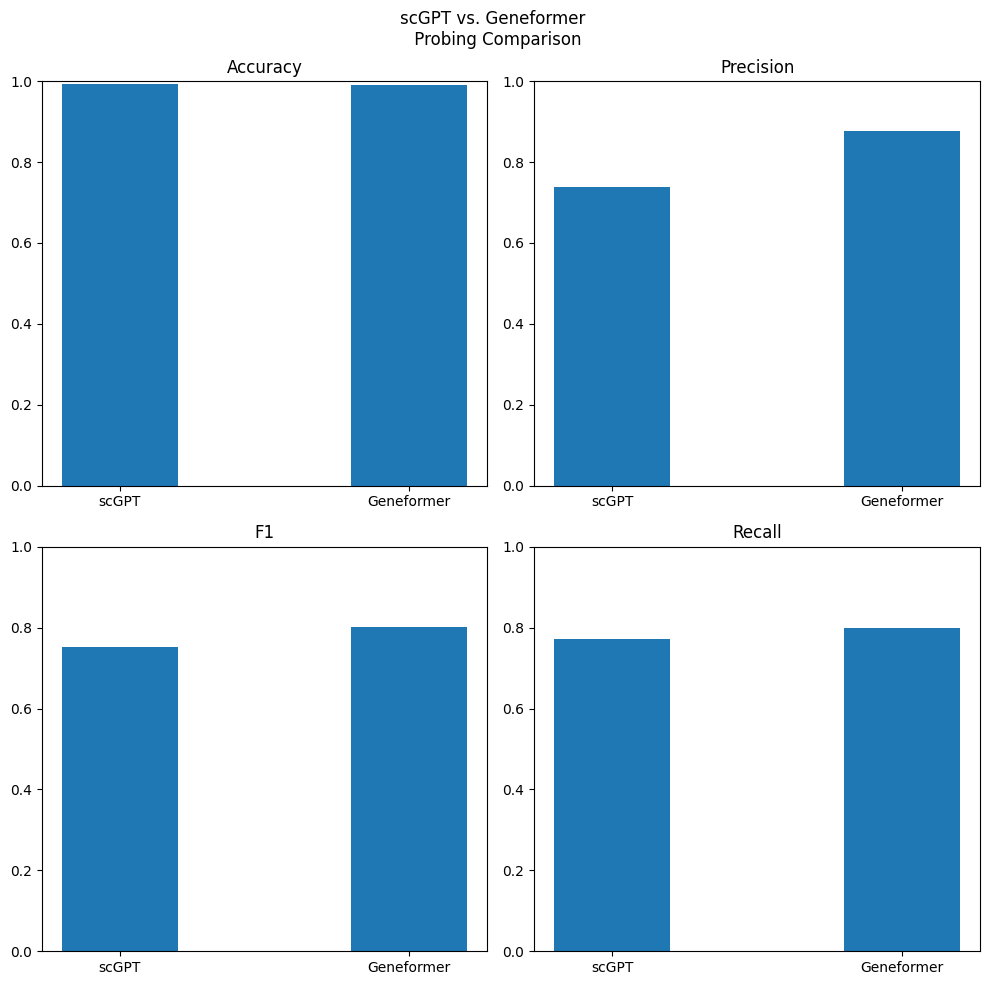

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

values_1 = [scgpt_results["accuracy"], geneformer_results["accuracy"]]
x = ["scGPT", "Geneformer"]
axs[0, 0].bar(x, values_1, width=0.4)
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_ylim([0, 1])

values_2 = [scgpt_results["precision"], geneformer_results["precision"]]
axs[0, 1].bar(x, values_2, width=0.4)
axs[0, 1].set_title("Precision")
axs[0, 1].set_ylim([0, 1])

values_3 = [scgpt_results["f1"], geneformer_results["f1"]]
axs[1, 0].bar(x, values_3, width=0.4)
axs[1, 0].set_title("F1")
axs[1, 0].set_ylim([0, 1])

values_4 = [scgpt_results["recall"], geneformer_results["recall"]]
axs[1, 1].bar(x, values_4, width=0.4)
axs[1, 1].set_title("Recall")
axs[1, 1].set_ylim([0, 1])

fig.suptitle("scGPT vs. Geneformer \n Probing Comparison")
fig.tight_layout()
plt.show()



## scGPT
- Accuracy: 99.2%
- Precision: 90.8%
- Recall: 79.1%
- Macro F1: 80.7%

## Geneformer
- Accuracy: 98.9%
- Precision: 71.6%
- Recall: 73.6%
- Macro F1: 77.3%

 (c) Helical 2024 - Developed by the Helical Team